In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Drop all NaN data.
Most of NaN data are not actuall lines. They are usually separations between acts/scenes

In [41]:
data = pd.read_csv('data/shakespeare-plays/Shakespeare_data.csv')
data = data.dropna()
data.sample(3)

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
49670,49671,King Lear,28.0,1.4.58,KING LEAR,Ha! sayest thou so?
50613,50614,King Lear,55.0,2.4.195,KING LEAR,Wherein I thee endow'd.
85097,85098,Richard III,61.0,5.3.262,RICHMOND,"The prayers of holy saints and wronged souls,"


# Data processing

 - Separate act/scene/line to make it easier for learning algorithm
 - Calculate how many words each line has. It in some way reflects if the player is a talktive person
 - Calculate how many letters each word has on average. This shows what type of word a person tends to use. Some people prefer shorter and easier words

In [42]:
#get info from line
actSceneLine = data['ActSceneLine']
aslSplit = actSceneLine.str.split('.', expand=True)

actLines = data['PlayerLine']
charPWord = actLines.str.len() #first hold total chars per line

wordPLine = actLines.str.split()
wordPLine = wordPLine.str.len() #words per line

charPWord = charPWord / wordPLine #characters per word

data_pro = pd.DataFrame()
data_pro['Player'] = data['Player']
data_pro['Play'] = data['Play']
data_pro['PlayerLineNumber'] = data['PlayerLinenumber']
data_pro['Act'] = aslSplit[0]
data_pro['Scene'] = aslSplit[1]
data_pro['Line'] = aslSplit[2]
data_pro['WordPerLine'] = wordPLine
data_pro['CharPerWord'] = charPWord

data_pro.sample(3)

#data_pro
#aslSplit
#charPWord
#actLines
#wordPLine

,Player,Play,PlayerLineNumber,Act,Scene,Line,WordPerLine,CharPerWord
77732,LYSIMACHUS,Pericles,10.0,4,6,22,7,5.857143
96273,TIMON,Timon of Athens,61.0,5,1,206,8,5.000000
73274,MONTANO,Othello,45.0,2,3,131,10,4.500000


# Encode string columns to number

In [43]:
# encoding from string to number
from sklearn import preprocessing
features = ['Player', 'Play']
    
for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(data_pro[feature])
    data_pro[feature] = le.transform(data_pro[feature])

data_pro.sample(3)

,Player,Play,PlayerLineNumber,Act,Scene,Line,WordPerLine,CharPerWord
44695,136,16,53.0,3,1,287,9,4.777778
33150,395,8,21.0,1,4,88,4,5.000000
54770,412,18,56.0,5,1,155,4,4.750000


Add infomation about previous line and next line

In [44]:
count = 0;
preIndex = 0;
thisIndex = 0;
for i, row in data_pro.iterrows():
    if (count > 0):
        if (count == 1):
            data_pro.loc[thisIndex, 'PrePlayer'] = data_pro.loc[thisIndex, 'Player']
            data_pro.loc[thisIndex, 'NextPlayer'] = data_pro.loc[i, 'Player']    
        else:
            data_pro.loc[thisIndex, 'PrePlayer'] = data_pro.loc[preIndex, 'Player']
            data_pro.loc[thisIndex, 'NextPlayer'] = data_pro.loc[i, 'Player']   
            if (i == 111394):
                data_pro.loc[i, 'PrePlayer'] = data_pro.loc[thisIndex, 'Player']
                data_pro.loc[i, 'NextPlayer'] = data_pro.loc[i, 'Player'] 
        
    preIndex = thisIndex
    thisIndex = i
    count += 1
data_pro.sample(3)

,Player,Play,PlayerLineNumber,Act,Scene,Line,WordPerLine,CharPerWord,PrePlayer,NextPlayer
27396,805,6,51.0,4,5,164,4,4.250000,805.0,333.0
92993,364,29,12.0,3,3,36,9,5.333333,364.0,364.0
36597,395,8,134.0,5,2,351,8,5.250000,395.0,395.0


# Visualization
Plot bar chart for average Word per Line and Letter per Word

Text(0,0.5,'Words per Line')

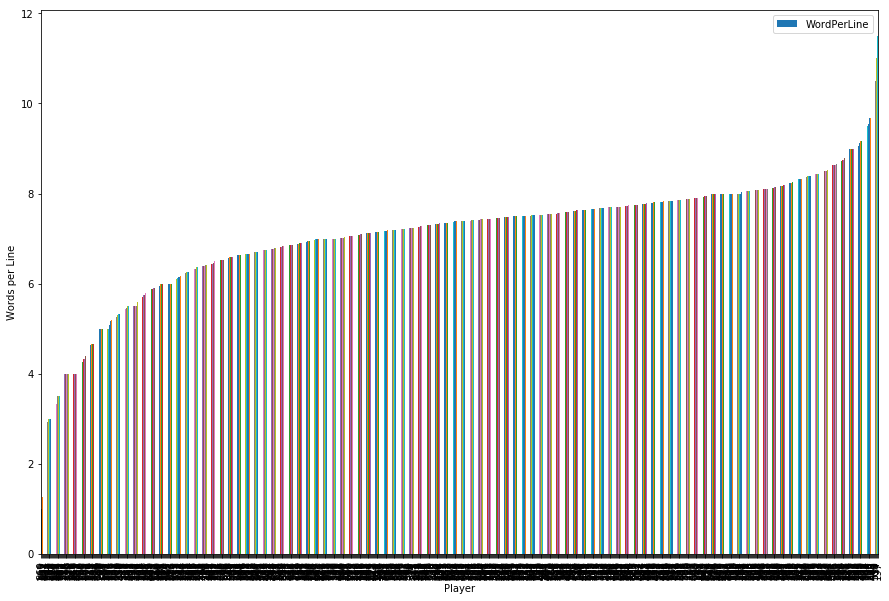

In [15]:
#visualization
data_plot = data_pro.groupby('Player').mean()

#data_sort = data_plot.sort_values('WordPerLine', ascending=True)

plt_wpl = data_plot.sort_values('WordPerLine', ascending=True).plot(y='WordPerLine', kind='bar', figsize=(15, 10))
plt_wpl.set_xlabel("Player")
plt_wpl.set_ylabel("Words per Line")

Text(0,0.5,'Letters Per Word')

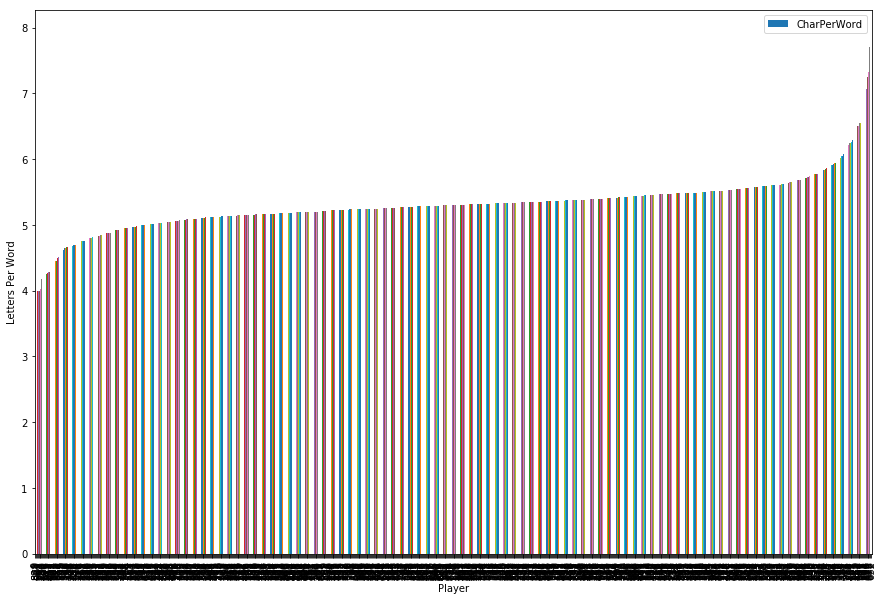

In [16]:
plt_wpl = data_plot.sort_values('CharPerWord', ascending=True).plot(y='CharPerWord', kind='bar', figsize=(15, 10))
plt_wpl.set_xlabel("Player")
plt_wpl.set_ylabel("Letters Per Word")

From the result, we can see most players' words per line falls in the interval from 6 to 8. And most players' letters per word falls in 5 to 6. Both of the properties are not very good at tell which player each line belongs to.

In [46]:
from sklearn.model_selection import train_test_split

data_x = data_pro.drop(['Player'], axis=1)
data_y = data_pro['Player']

perc_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=perc_test)

#data_x
#data_y
#X_train
#y_test

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

clfr = RandomForestClassifier()

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clfr, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

clfr = grid_obj.best_estimator_

clfr.fit(X_train, y_train)

/home/kaidong/Softwares/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
predictions = clfr.predict(X_test)
print(accuracy_score(y_test, predictions))

0.6850839237316343


From the result, first the classifier was trained from the dataset with only addition of word per line and letter per word. The accuracy is 0.5077. After adding information about previous and next players, the accuracy is increased to 0.6851